# Explore Phase: New Business Location Predictor

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import acquire as a
from env import api

# imports to deal with location data in Python
import geopandas as gpd
from shapely.geometry import Point

# imports to interact with google places API
import requests
import json

# preprocessing
from sklearn.model_selection import train_test_split

# modeling
from scipy.stats import pearsonr
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = a.get_combined_data()
df.head().T

,0,1,2,3,4
geography,110100,110300,110500,110600,110700
total_pop,3153,3114,2430,5645,1079
sex_ratio,161.7,99.9,100.3,275.1,129.1
old_age_dep_ratio,29.0,13.0,25.4,15.0,49.2
child_dep_ratio,6.4,43.4,89.8,11.6,35.8
total_hispanic_latino,1758,1589,1982,4763,933
household_med_income,52659,43875,10518,16712,18700
centroid_lat,29.426165,29.41432,29.417071,29.429211,29.438939
centroid_long,-98.490526,-98.480848,-98.50908,-98.507837,-98.503691
latitude,NaN,NaN,NaN,NaN,NaN


### EDA and Preprocessing for Modeling

In [3]:
# now I need to scale the feature cols 


In [4]:
# splitting data into train and test
# not using val due to very small number
# of studios making samples too small.
train, test = train_test_split(df, random_state=9751, 
                 stratify=df['has_yoga'], train_size = 0.7)

In [5]:
train.head()

,geography,total_pop,sex_ratio,old_age_dep_ratio,child_dep_ratio,total_hispanic_latino,household_med_income,centroid_lat,centroid_long,latitude,longitude,has_yoga
58,121803,4998,104.6,22.3,46.7,2563,70101,29.554509,-98.365750,NaN,NaN,False
41,121300,6693,96.0,37.9,42.7,2697,69500,29.519699,-98.383996,NaN,NaN,False
363,191818,4955,119.3,30.3,28.9,1944,80024,29.621480,-98.478567,29.610592,-98.491604,True
273,181718,4968,101.0,19.3,35.7,2708,76891,29.527821,-98.671639,NaN,NaN,False
23,121000,7668,76.7,18.1,39.0,3732,50146,29.532220,-98.445465,NaN,NaN,False


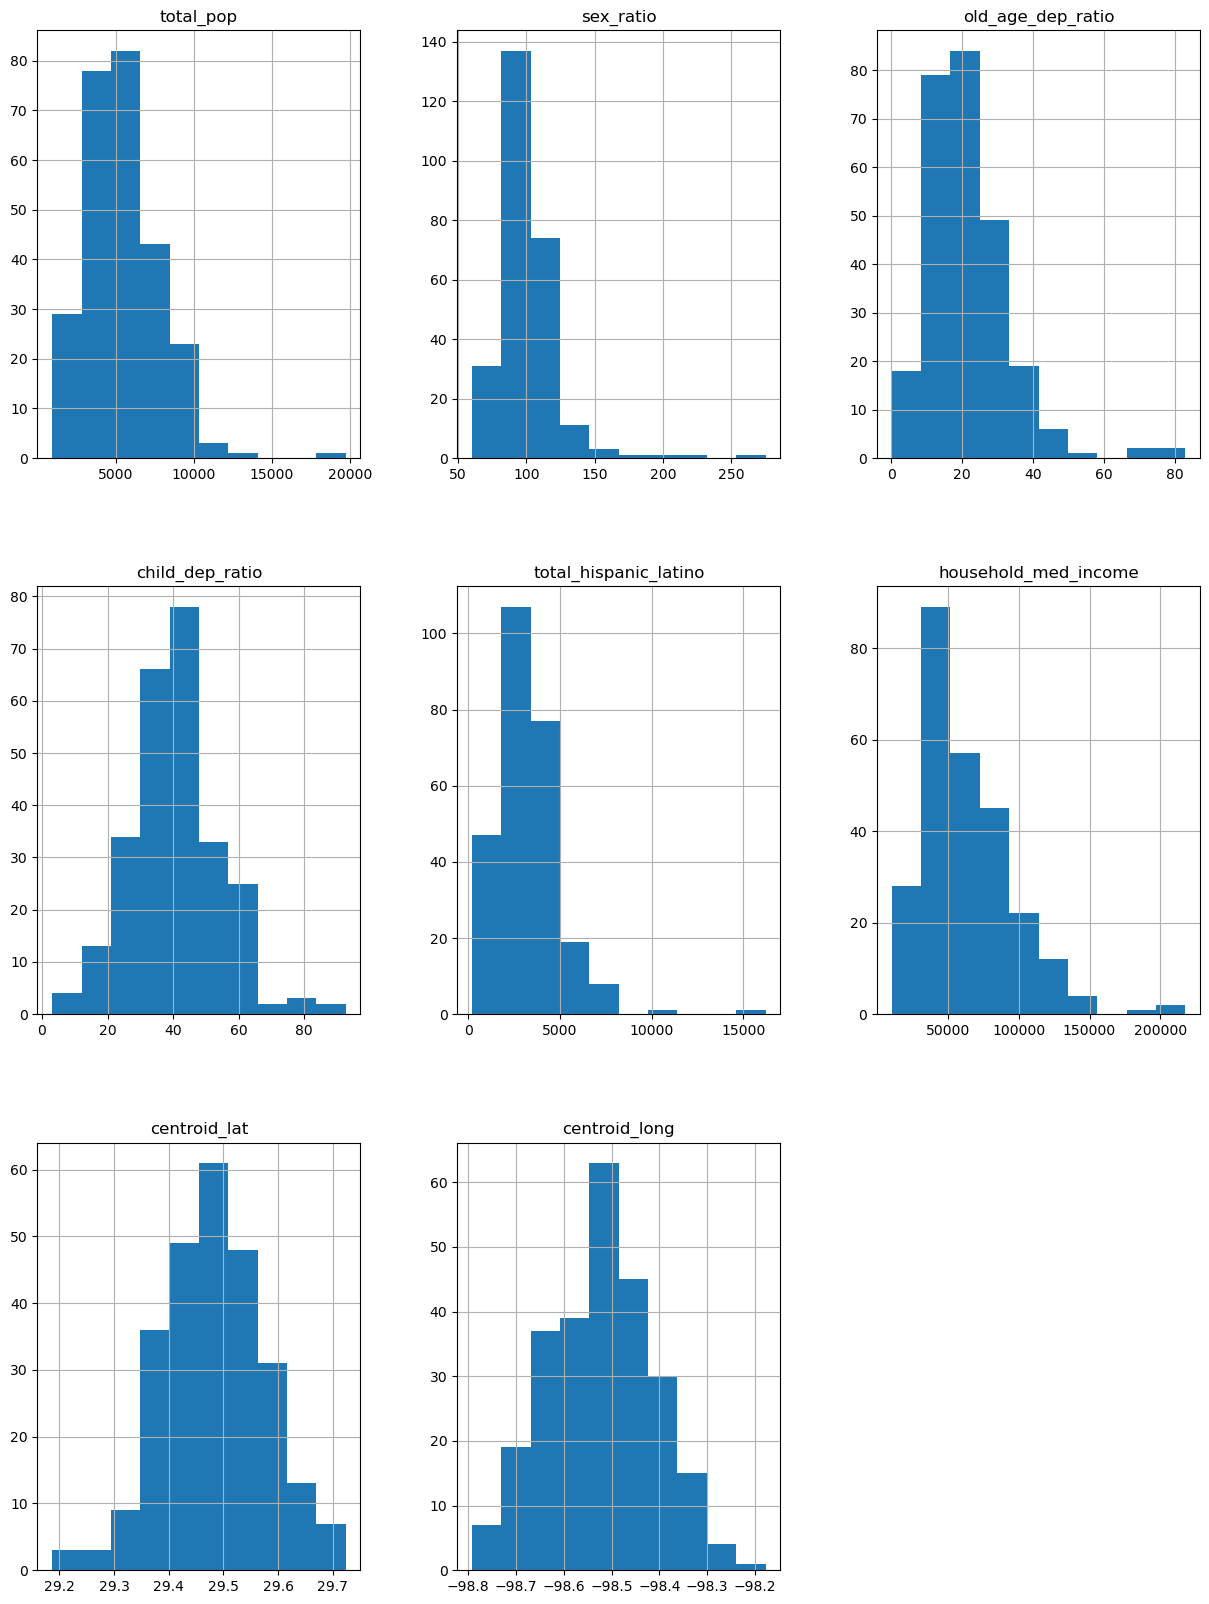

In [6]:
#Hist plot to show distribution of each column in the dataframe
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
train.drop(columns=['geography', 'latitude', 'longitude']).hist(ax = ax)
plt.show()

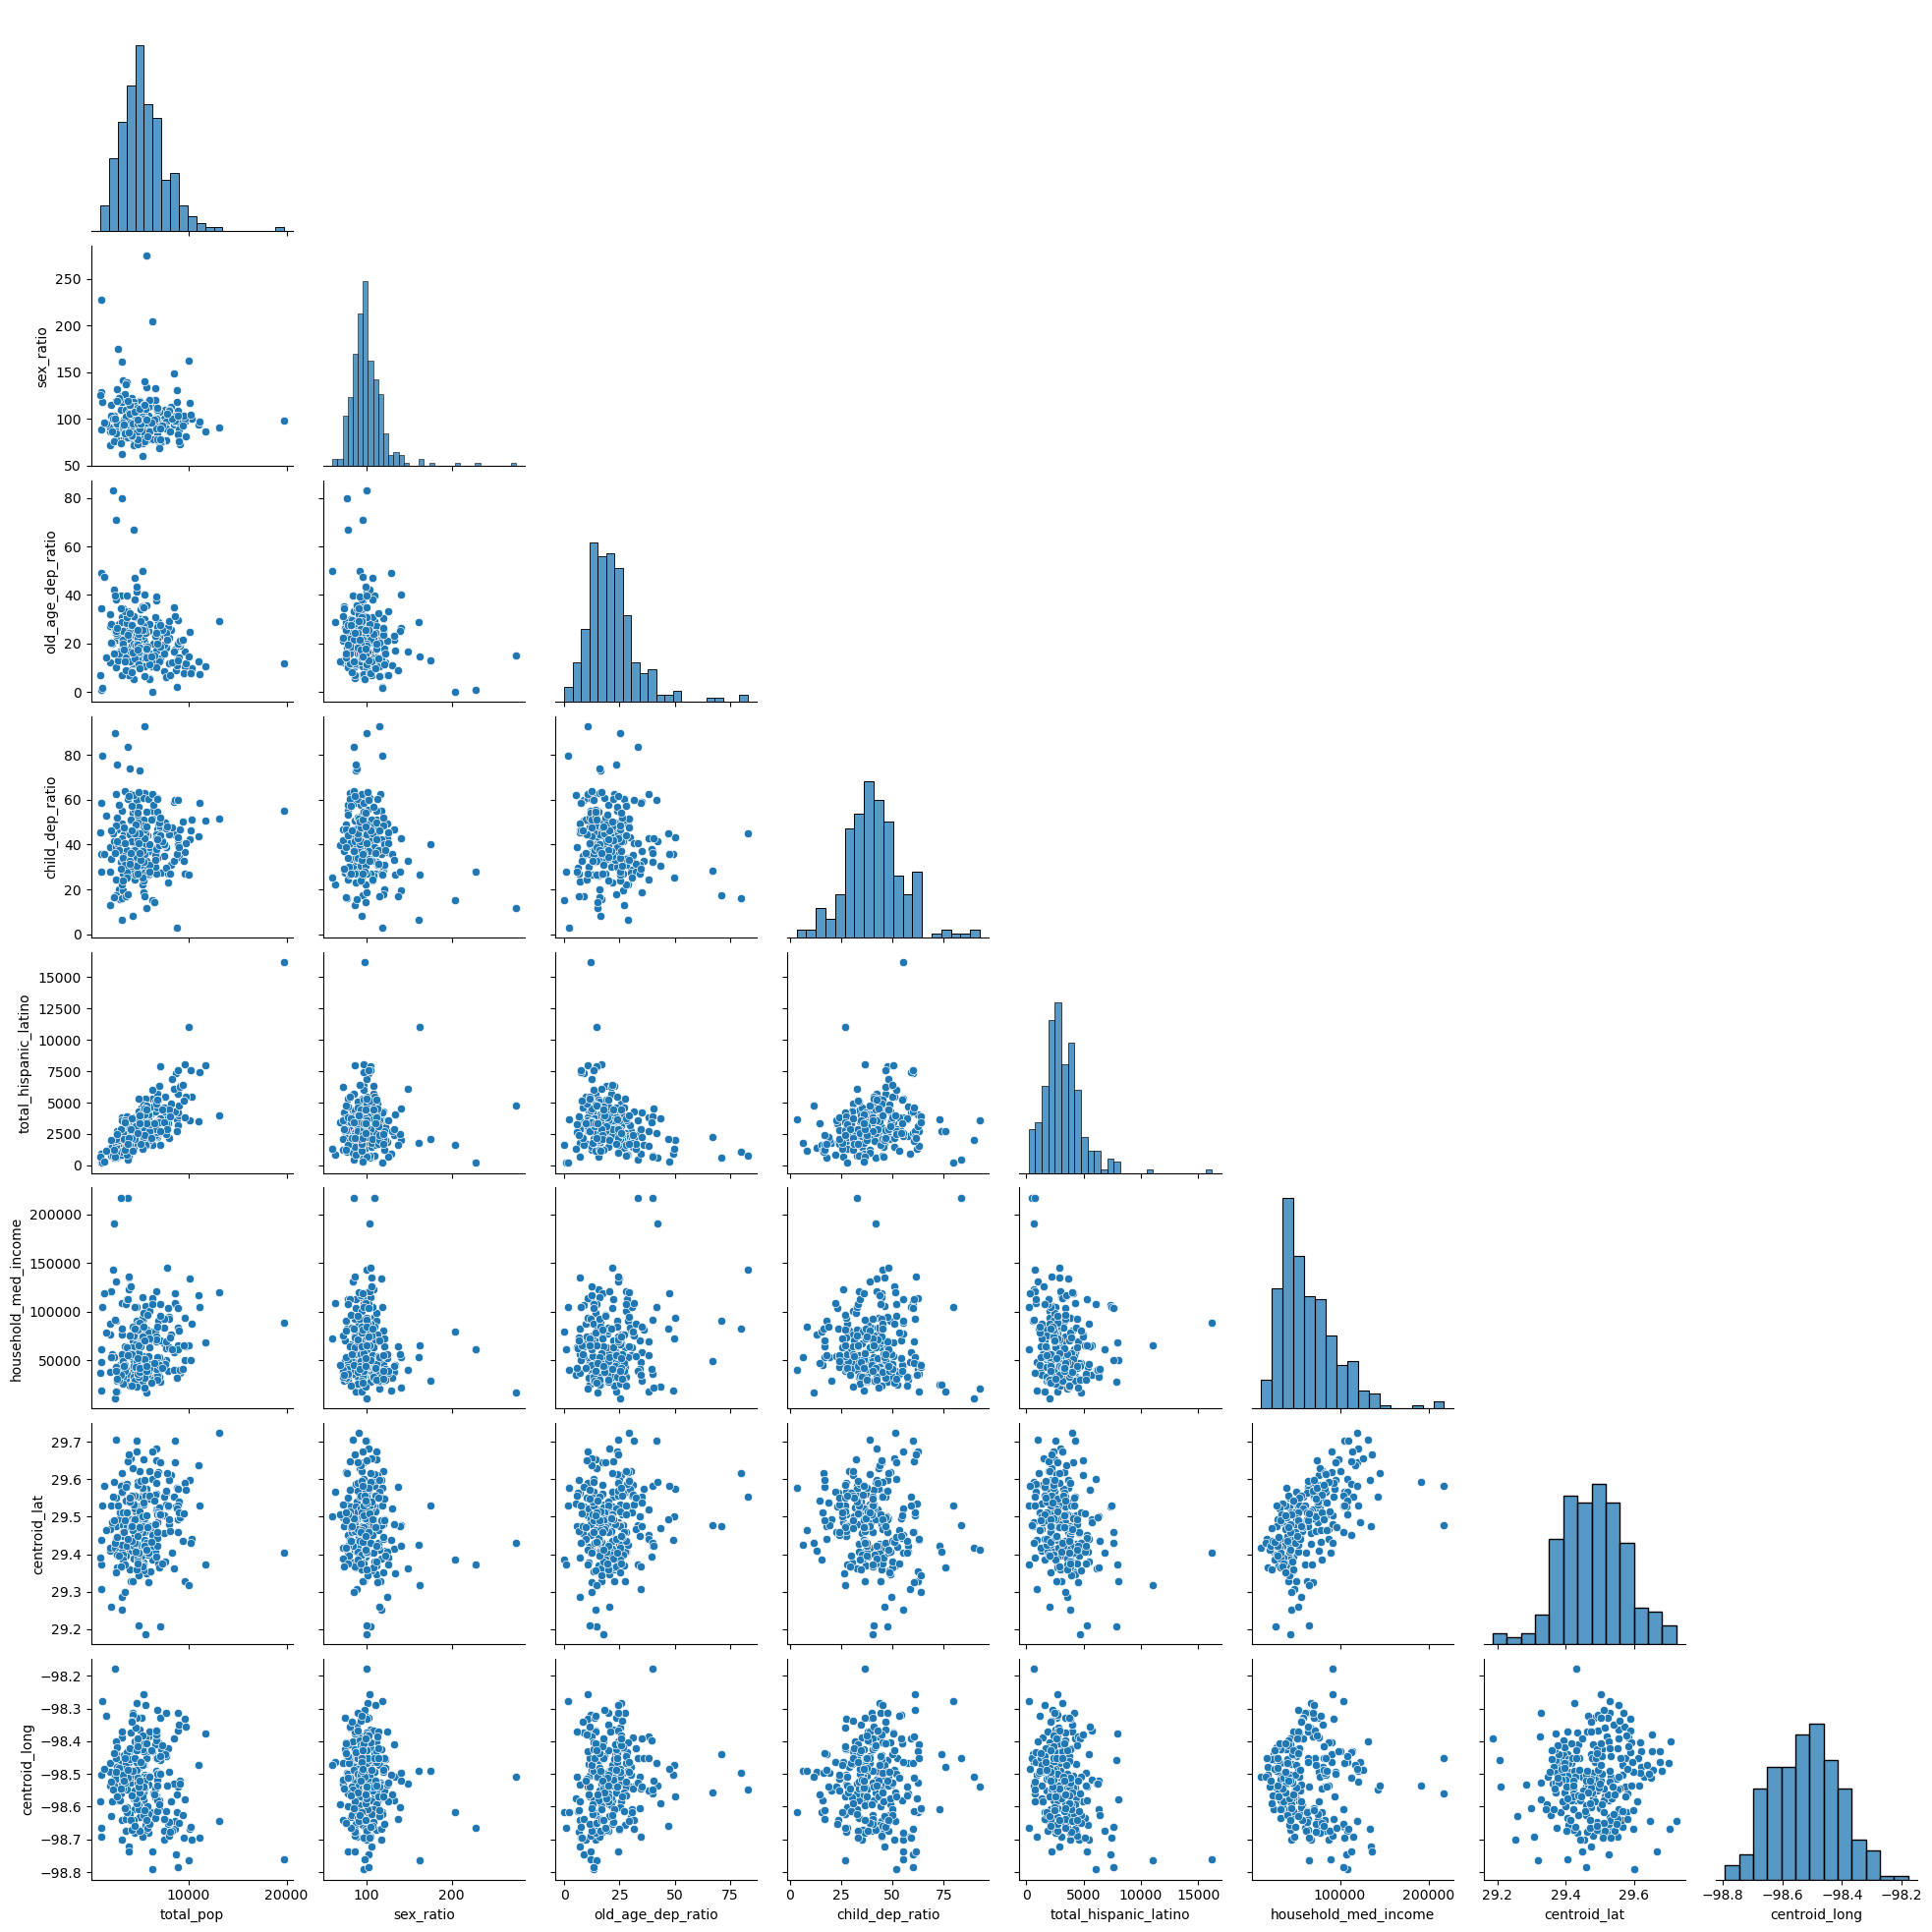

In [7]:
sns.pairplot(train.drop(columns=['geography', 'latitude', 'longitude', 'has_yoga']), corner=True)

In [8]:
# there appears to be a positive correlation between latitude and income

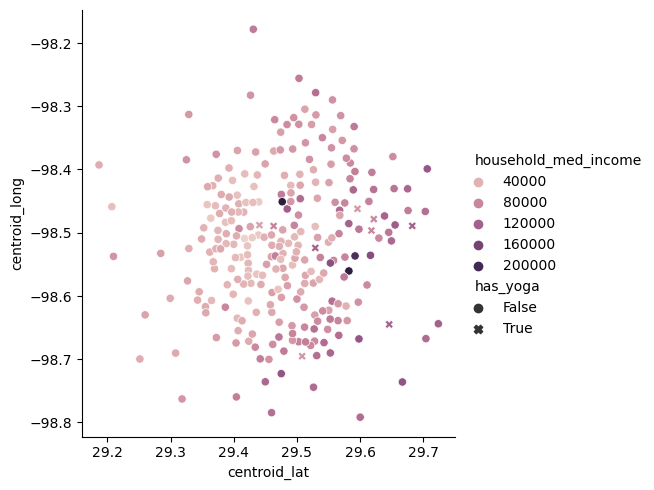

In [9]:
sns.relplot(data=train, x='centroid_lat', y='centroid_long', hue='household_med_income', style='has_yoga')

In [10]:
# it's hard to make out clear clusters in all dimensions here, but
# this does seem to show the correlation between income and yoga as
# well as wealth clusters on the northeast and southeast
# studios may be in poorer areas near richer areas which would make
# sense as rents may be lower, but still close enough to serve wealthy
# clients
# Going to explore clusters on these features with k between 2 and 10

In [11]:
target_col_name = 'has_yoga'
feature_target_corr = {}
for col in train.drop(columns=['geography', 'latitude', 'longitude']):
    if target_col_name != col:
        feature_target_corr[col + '_' + target_col_name] = \
            pearsonr(train[col], train[target_col_name])[0]\
            , pearsonr(train[col], train[target_col_name])[1]
print("Feature-Target Correlations, p-values")
print(feature_target_corr)

Feature-Target Correlations, p-values
{'total_pop_has_yoga': (-0.00618044368369202, 0.9209973987238368), 'sex_ratio_has_yoga': (-0.0003022736600612032, 0.9961298508792851), 'old_age_dep_ratio_has_yoga': (0.10953973337972217, 0.07788806507365327), 'child_dep_ratio_has_yoga': (-0.1698628787500684, 0.006037439234588488), 'total_hispanic_latino_has_yoga': (-0.09870146612035471, 0.1123487595138162), 'household_med_income_has_yoga': (0.1422055377858407, 0.02181259825233574), 'centroid_lat_has_yoga': (0.17251873049480732, 0.005281858578243495), 'centroid_long_has_yoga': (-0.01672982624145614, 0.7883303819744173)}


In [12]:
# it looks like the only feature that has a significant
# correlation to has yoga is household_median_income

In [13]:


# Separating features from target and dropping geography, lat, long for modeling:
X_train = train.drop(columns=['geography', 'latitude', 'longitude', 'has_yoga'])
X_test = test.drop(columns=['geography', 'latitude', 'longitude', 'has_yoga'])
y_train = train[['has_yoga']]
y_test = test[['has_yoga']]



In [14]:
# all features need scaling
X_cols = X_train.columns.tolist()
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_cols)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_cols)


In [15]:
X_train_scaled.head()

,total_pop,sex_ratio,old_age_dep_ratio,child_dep_ratio,total_hispanic_latino,household_med_income,centroid_lat,centroid_long
0,0.216140,0.206977,0.268116,0.486607,0.147820,0.287818,0.684976,0.694309
1,0.306487,0.166977,0.456522,0.441964,0.156191,0.284915,0.620112,0.664586
2,0.213848,0.275349,0.364734,0.287946,0.109147,0.335752,0.809765,0.510526
3,0.214541,0.190233,0.231884,0.363839,0.156879,0.320618,0.635246,0.196009
4,0.358456,0.077209,0.217391,0.400670,0.220855,0.191425,0.643444,0.564451


### Modeling

In [16]:
# Establish a baseline
# since has_studio=False is by far the dominant class
# will assign that as the baseline model.
y_train['baseline'] = False
y_test['baseline'] = False

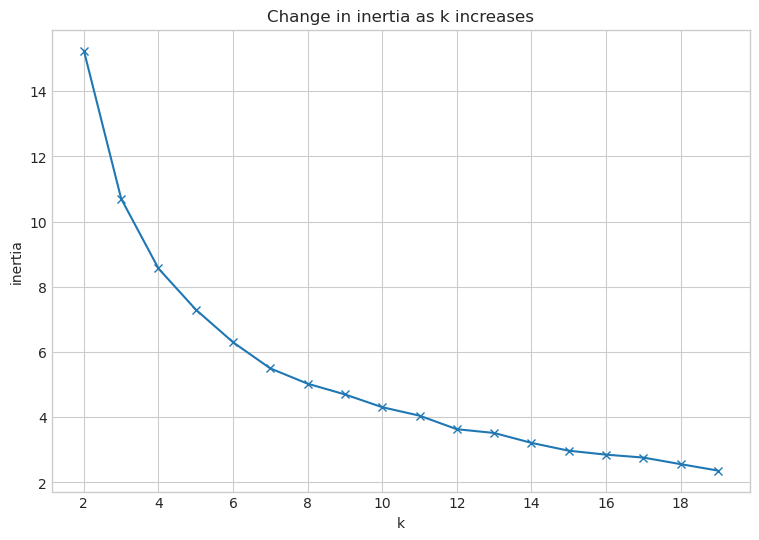

In [17]:
cluster_vars = ['household_med_income', 'centroid_lat', 'centroid_long']
X_train_clust = X_train_scaled[cluster_vars]

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_train_clust).inertia_ for k in range(2, 20)}).plot(marker='x')
    plt.xticks(range(2, 20, 2))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')


In [18]:
# we see a break between 3 and 7 which is consistent with what we saw in the viz.
# start with k = 5

In [19]:
k = 7
cluster_name = 'income_cluster'


In [20]:
def create_clusters(X_train_scaled, k, cluster_vars):
    # create kmean object
    kmeans = KMeans(n_clusters=k, random_state = 13)

    # fit to train and assign cluster ids to observations
    kmeans.fit(X_train[cluster_vars])

    return kmeans


In [21]:
kmeans = create_clusters(X_train_scaled, k, cluster_vars)


In [22]:
# get the centroids for each distinct cluster...

def get_centroids(kmeans, cluster_vars, cluster_name):
    # get the centroids for each distinct cluster...

    centroid_col_names = ['centroid_' + i for i in cluster_vars]

    centroid_df = pd.DataFrame(kmeans.cluster_centers_, 
                               columns=centroid_col_names).reset_index().rename(columns={'index': cluster_name})

    return centroid_df


In [23]:
centroid_df = get_centroids(kmeans, cluster_vars, cluster_name)


In [24]:
centroid_df

,income_cluster,centroid_household_med_income,centroid_centroid_lat,centroid_centroid_long
0,0,29349.500000,29.423273,-98.515023
1,1,85072.634146,29.536887,-98.524800
2,2,208628.666667,29.550196,-98.516154
3,3,67280.704545,29.493882,-98.484145
4,4,134284.625000,29.594327,-98.570059
5,5,110068.884615,29.588841,-98.571622
6,6,46736.523256,29.437378,-98.519083


In [25]:
# label cluster for each observation in X_train

clusters = pd.DataFrame(kmeans.predict(X_train[cluster_vars]), 
                    columns=[cluster_name], index=X_train.index)

clusters_centroids = clusters.merge(centroid_df, on=cluster_name, copy=False).set_index(clusters.index.values)

X_train = pd.concat([X_train, clusters_centroids], axis=1)


In [26]:
# label cluster for each observation in X_test

clusters = pd.DataFrame(kmeans.predict(X_test[cluster_vars]), 
                    columns=[cluster_name], index=X_test.index)

clusters_centroids = clusters.merge(centroid_df, on=cluster_name, copy=False).set_index(clusters.index.values)

X_test = pd.concat([X_test, clusters_centroids], axis=1)


In [27]:
X_train

,total_pop,sex_ratio,old_age_dep_ratio,child_dep_ratio,total_hispanic_latino,household_med_income,centroid_lat,centroid_long,income_cluster,centroid_household_med_income,centroid_centroid_lat,centroid_centroid_long
58,4998,104.6,22.3,46.7,2563,70101,29.554509,-98.365750,3,67280.704545,29.493882,-98.484145
41,6693,96.0,37.9,42.7,2697,69500,29.519699,-98.383996,3,67280.704545,29.493882,-98.484145
363,4955,119.3,30.3,28.9,1944,80024,29.621480,-98.478567,3,67280.704545,29.493882,-98.484145
273,4968,101.0,19.3,35.7,2708,76891,29.527821,-98.671639,3,67280.704545,29.493882,-98.484145
23,7668,76.7,18.1,39.0,3732,50146,29.532220,-98.445465,3,67280.704545,29.493882,-98.484145
...,...,...,...,...,...,...,...,...,...,...,...,...
304,5461,115.1,6.5,16.8,2451,70257,29.596946,-98.609920,4,134284.625000,29.594327,-98.570059
82,6154,96.1,14.5,51.0,2143,26332,29.432014,-98.426944,4,134284.625000,29.594327,-98.570059
203,5718,99.4,17.9,48.0,4427,44197,29.413117,-98.639374,2,208628.666667,29.550196,-98.516154
194,2682,119.7,26.2,51.9,2514,30556,29.445414,-98.567393,2,208628.666667,29.550196,-98.516154


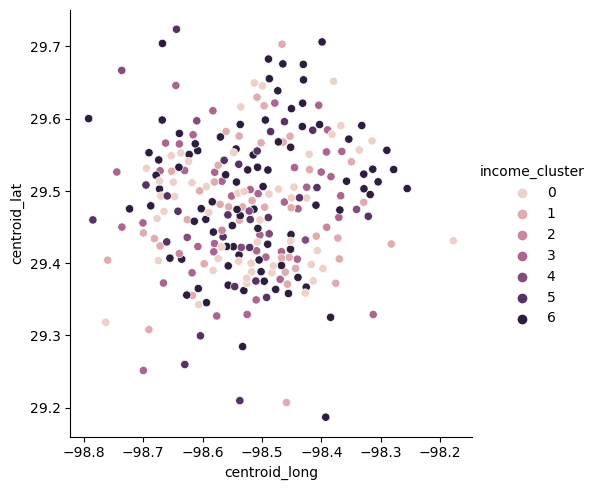

In [28]:
sns.relplot(data = X_train, x='centroid_long', y='centroid_lat', hue='income_cluster')

In [42]:
# visually, there are no distinct clusters at k=3 to k=7

In [29]:
y_train.head()

,has_yoga,baseline
58,False,False
41,False,False
363,True,False
273,False,False
23,False,False


In [30]:
rf1 = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=2,
                            n_estimators=100,
                            max_depth=5, 
                            random_state=123)
rf1.fit(X_train, y_train.has_yoga)

RandomForestClassifier(max_depth=5, min_samples_leaf=2, random_state=123)

In [31]:
print(rf1.feature_importances_)


[0.09169437 0.05909935 0.08119718 0.148887   0.10497155 0.10985938
 0.12946044 0.10986843 0.02231889 0.03282135 0.04936406 0.06045799]


In [32]:
# it appears cluster is one of the less important features

In [33]:
y_pred = rf1.predict(X_train)

In [34]:
y_pred_proba = rf1.predict_proba(X_train)


In [35]:
print('Accuracy of random forest classifier on training set: {:.6f}'
     .format(rf1.score(X_train, y_train.has_yoga)))


Accuracy of random forest classifier on training set: 0.976923


In [36]:
print(confusion_matrix(y_train.has_yoga, y_pred))


[[251   0]
 [  6   3]]


In [37]:
# this is at least beating baseline

In [38]:
# v. baseline
print(confusion_matrix(y_train.has_yoga, y_train.baseline))


[[251   0]
 [  9   0]]


In [39]:
print(classification_report(y_train.has_yoga, y_pred))


              precision    recall  f1-score   support

       False       0.98      1.00      0.99       251
        True       1.00      0.33      0.50         9

    accuracy                           0.98       260
   macro avg       0.99      0.67      0.74       260
weighted avg       0.98      0.98      0.97       260



In [40]:
# baseline performance:
print(classification_report(y_train.has_yoga, y_train.baseline))

              precision    recall  f1-score   support

       False       0.97      1.00      0.98       251
        True       0.00      0.00      0.00         9

    accuracy                           0.97       260
   macro avg       0.48      0.50      0.49       260
weighted avg       0.93      0.97      0.95       260



In [41]:
# recall of .33 on the True class is the metric of interest
# as some false positives may indicate areas that would be 
# good locations for studios but don't have them yet.

In [43]:
# now to try on test dataset
y_pred_test = rf1.predict(X_test)

In [44]:
y_test

,has_yoga,baseline
250,False,False
319,False,False
139,False,False
196,False,False
259,False,False
...,...,...
271,False,False
338,False,False
274,False,False
96,False,False


In [45]:
print(classification_report(y_test.has_yoga, y_pred_test))


              precision    recall  f1-score   support

       False       0.96      1.00      0.98       108
        True       0.00      0.00      0.00         4

    accuracy                           0.96       112
   macro avg       0.48      0.50      0.49       112
weighted avg       0.93      0.96      0.95       112



In [47]:
print(confusion_matrix(y_test.has_yoga, y_pred_test))


[[108   0]
 [  4   0]]


In [48]:
# with a recall score of zero and an accuracy of  this model did not beat baseline in the wild yet.